In [1]:
import torch
import copy
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F

from collections import OrderedDict

import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train_dataset = datasets.MNIST(root='MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = datasets.MNIST(root='MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)

C:\Users\WorkStation\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


**Functions**

In [3]:
def data_split(args):
    dataset_list=[]

    num_data_arr = np.ones((args.num_clients,), dtype=int) * int(len(train_dataset)/args.num_clients)
    dataset_list = torch.utils.data.random_split(train_dataset, num_data_arr)
    return dataset_list

def list_np_tensor(param_data):
    data = np.concatenate((param_data['net.0.weight'].cpu().numpy(),np.expand_dims(param_data['net.0.bias'].cpu().numpy(), axis=1)),axis=1)
    data = torch.Tensor(data)
    return data

**Model**

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(28*28, 10)
                                )

    def forward(self, x):
        x = x.view(-1,28*28)
        out = self.net(x)
        return out

In [5]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(nn.Linear(7851, 785),
                                    nn.Linear(785, 50),
                                    nn.Linear(50, self.hidden_dim)
                                    )
            
    def forward(self, x):
        output = self.encoder(x)
        return output


class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()

        self.hidden_dim = hidden_dim
        self.decoder = nn.Sequential(nn.Linear(self.hidden_dim, 50),
                                    nn.Linear(50, 785),
                                    nn.Linear(785, 7851)
                                    )
            
    def forward(self, x):
        output = self.decoder(x)
        return output

**Train**

In [6]:
def define_client(partition, decoder, server_enc_data, r, num, args):
    train_loader = DataLoader(partition['train'][num], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = Net().to(device)

    else:
        global_weights = OrderedDict()
        net = Net().to(device)

        w_avg = decoder(server_enc_data)[:,:-1].view((-1, 785))
        
        global_weights['net.0.weight'] = w_avg[:,:784]
        global_weights['net.0.bias'] = w_avg[:,784:].squeeze()
        
        net.load_state_dict(global_weights)

    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    return net, train_loader, criterion, optimizer

In [7]:
def train(net, train_loader, criterion, optimizer, args):
    net.train()

    for epoch in range(args.num_epochs):        
        for images, labels in iter(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
    return net

In [8]:
def client_encode(net, r, encoder):
    round_tensor = torch.tensor(r).view(-1, 1).to(device)

    param_data = copy.deepcopy(net.state_dict())
    tensor_data = list_np_tensor(param_data).view(-1,7850).to(device)
    dt_r = torch.cat((tensor_data, round_tensor), dim=1)
    encoded_data = encoder(dt_r)
    return encoded_data

In [9]:
def Dec_Fed_AVG(model, encoder, decoder, client_enc_data_list, r, args):
    model.train()
    decoded_data_list = []
    global_weights = OrderedDict()

    for i in range(args.num_clients):
        client_enc_data_list[i] = client_enc_data_list[i].to(device)
        #out = decoder(client_enc_data_list[i]).view((-1, 785)).cpu().detach().numpy()    #[:,:-1]로 round 삭제
        out = decoder(client_enc_data_list[i])[:,:-1].view((-1, 785)).cpu().detach().numpy()    
        decoded_data_list.append(out)

    w_avg = np.mean(decoded_data_list, axis=0)
    global_weights['net.0.weight'] = torch.tensor(w_avg[:,:784]).clone().detach()
    global_weights['net.0.bias'] = torch.tensor(w_avg[:,784:].squeeze()).clone().detach()

    model.load_state_dict(global_weights)

    # === encoding === #
    round_tensor = torch.tensor(r).to(device)
    tensor_data = list_np_tensor(global_weights).view((-1,7850)).to(device)
    dt_r = torch.cat((tensor_data, round_tensor), dim=1)
    server_enc_data = encoder(dt_r)

    #tensor_data = list_np_tensor(global_weights).view((-1,7850)).to(device)
    #server_enc_data = encoder(dt_r)

    return model, server_enc_data

In [10]:
def save_param_with_round(param_data, round_list, args):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    
    round_tensor = torch.tensor(round_list)
    dt_r = torch.cat((dt, round_tensor), dim=1)
    
    dtf = pd.DataFrame(dt_r)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')


In [11]:
def test(model, partition, criterion, args):
    test_loader = DataLoader(partition['test'], batch_size=args.batch_size, shuffle=True)
    model.eval()
        
    correct = 0 
    total = 0 
    loss = 0
    round_accuracy = 0
    round_loss = 0

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    
    round_loss = loss / len(test_loader)
    round_accuracy = (correct / total) * 100.0
    
    return round_loss, round_accuracy

In [12]:
def experiment(partition, args):
    encoder = Encoder(args.hidden_dim)
    decoder = Decoder(args.hidden_dim)
    model = Net()
    encoder.load_state_dict(torch.load(args.enc_path))
    decoder.load_state_dict(torch.load(args.dec_path))

    encoder, decoder, model = encoder.to(device), decoder.to(device), model.to(device)
    
    server_enc_data = []
    round_losses = []
    round_acces = []


    for r in range(args.num_rounds):
        client_enc_data_list = []

        for num in range(args.num_clients):
            net, train_loader, criterion, optimizer = define_client(partition, decoder, server_enc_data,r, num, args)
            net = train(net, train_loader, criterion, optimizer, args)
            client_enc_data = client_encode(net, r, encoder)
            client_enc_data_list.append(client_enc_data)

        model, server_enc_data = Dec_Fed_AVG(model, encoder, decoder, client_enc_data_list, [[r]], args)
        round_loss, round_acc = test(model, partition, criterion, args)

        if (r+1)%50 == 0:
            print(f'[Round: {r}]  Round Loss: {round_loss}  Round Acc: {round_acc:.2f}')

        round_losses.append(round_loss)
        round_acces.append(round_acc)
        
    return round_losses, round_acces

In [13]:
def plot_loss(round_loss, round_acc):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1,2,1)
    plt.plot(round_loss, label = 'Loss')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(round_acc, label = 'Accuracy')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.show()
    

===== reverse: False =====
num_data: 100
[Round: 49]  Round Loss: 0.48881460465490817  Round Acc: 91.15
[Round: 99]  Round Loss: 0.9082244172692299  Round Acc: 90.60
[Round: 149]  Round Loss: 2.022595319151878  Round Acc: 90.06
[Round: 199]  Round Loss: 5.290016289353371  Round Acc: 89.78
[Round: 249]  Round Loss: 15.011036434173583  Round Acc: 89.64
[Round: 299]  Round Loss: 43.818576917648315  Round Acc: 89.52
[Round: 349]  Round Loss: 129.45850322723388  Round Acc: 89.46
[Round: 399]  Round Loss: 382.61279399871825  Round Acc: 89.43
[Round: 449]  Round Loss: 1131.4370101928712  Round Acc: 89.42
[Round: 499]  Round Loss: 3352.3324627685547  Round Acc: 89.42
[Round: 549]  Round Loss: 9924.673220214843  Round Acc: 89.43
[Round: 599]  Round Loss: 29390.165278320314  Round Acc: 89.43
[Round: 649]  Round Loss: 86854.5828515625  Round Acc: 89.42
[Round: 699]  Round Loss: 257780.3343359375  Round Acc: 89.42
[Round: 749]  Round Loss: 762616.3534375  Round Acc: 89.42
[Round: 799]  Round Loss:

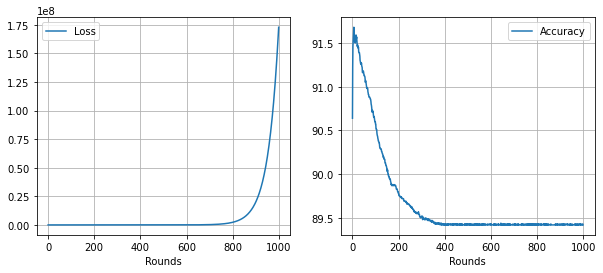

num_data: 500
[Round: 49]  Round Loss: 0.292349234521389  Round Acc: 92.06
[Round: 99]  Round Loss: 0.2812380660325289  Round Acc: 92.22
[Round: 149]  Round Loss: 0.2740740426629782  Round Acc: 92.32
[Round: 199]  Round Loss: 0.27173632860183716  Round Acc: 92.32
[Round: 249]  Round Loss: 0.27417462438344953  Round Acc: 92.31
[Round: 299]  Round Loss: 0.28189037799835204  Round Acc: 92.31
[Round: 349]  Round Loss: 0.2942571745812893  Round Acc: 92.16
[Round: 399]  Round Loss: 0.31376339867711067  Round Acc: 91.87
[Round: 449]  Round Loss: 0.342008221745491  Round Acc: 91.17
[Round: 499]  Round Loss: 0.38872808948159215  Round Acc: 90.01
[Round: 549]  Round Loss: 0.476187607049942  Round Acc: 87.78
[Round: 599]  Round Loss: 0.9717874979972839  Round Acc: 71.15
[Round: 649]  Round Loss: 33.85508256912232  Round Acc: 0.01
[Round: 699]  Round Loss: 45.32269058227539  Round Acc: 0.01
[Round: 749]  Round Loss: 51.35540367126465  Round Acc: 0.01
[Round: 799]  Round Loss: 56.79673374176026  Ro

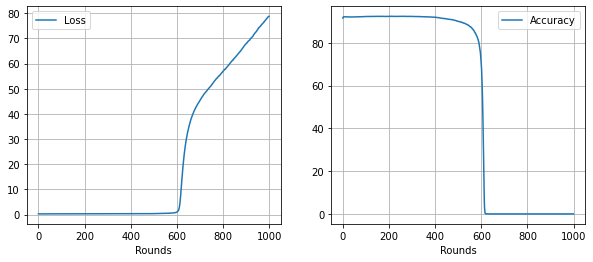

num_data: 1000
[Round: 49]  Round Loss: 0.2971113953739405  Round Acc: 92.05
[Round: 99]  Round Loss: 0.30480710133910177  Round Acc: 92.02
[Round: 149]  Round Loss: 0.3026474297046661  Round Acc: 92.02
[Round: 199]  Round Loss: 0.29895703598856926  Round Acc: 92.07
[Round: 249]  Round Loss: 0.2955658044666052  Round Acc: 92.08
[Round: 299]  Round Loss: 0.29180690661072733  Round Acc: 92.12
[Round: 349]  Round Loss: 0.28906659796833994  Round Acc: 92.18
[Round: 399]  Round Loss: 0.28588177606463433  Round Acc: 92.20
[Round: 449]  Round Loss: 0.28362766802310946  Round Acc: 92.26
[Round: 499]  Round Loss: 0.28121833078563213  Round Acc: 92.27
[Round: 549]  Round Loss: 0.27875707849860193  Round Acc: 92.32
[Round: 599]  Round Loss: 0.27691116742789745  Round Acc: 92.34
[Round: 649]  Round Loss: 0.2748903390020132  Round Acc: 92.30
[Round: 699]  Round Loss: 0.2736419255286455  Round Acc: 92.34
[Round: 749]  Round Loss: 0.27249023333191874  Round Acc: 92.36
[Round: 799]  Round Loss: 0.2709

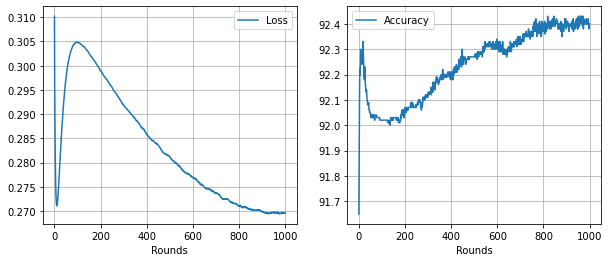

===== reverse: True =====
num_data: 100
[Round: 49]  Round Loss: 0.27931507110595705  Round Acc: 92.14
[Round: 99]  Round Loss: 0.2758771475404501  Round Acc: 92.23
[Round: 149]  Round Loss: 0.2738155749440193  Round Acc: 92.25
[Round: 199]  Round Loss: 0.27281757242977617  Round Acc: 92.36
[Round: 249]  Round Loss: 0.27301989182829856  Round Acc: 92.38
[Round: 299]  Round Loss: 0.27432661592960356  Round Acc: 92.35
[Round: 349]  Round Loss: 0.2761488688737154  Round Acc: 92.41
[Round: 399]  Round Loss: 0.2789319630712271  Round Acc: 92.31
[Round: 449]  Round Loss: 0.28214132361114025  Round Acc: 92.34
[Round: 499]  Round Loss: 0.2860872311890125  Round Acc: 92.28
[Round: 549]  Round Loss: 0.2901782611757517  Round Acc: 92.17
[Round: 599]  Round Loss: 0.2960858422145247  Round Acc: 92.09
[Round: 649]  Round Loss: 0.30115686036646366  Round Acc: 92.04
[Round: 699]  Round Loss: 0.3065175546705723  Round Acc: 91.97
[Round: 749]  Round Loss: 0.3142410659044981  Round Acc: 91.68
[Round: 799

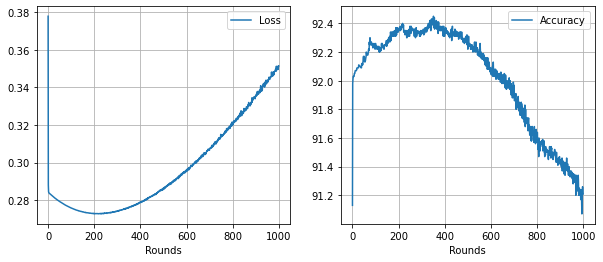

num_data: 500
[Round: 49]  Round Loss: 0.27790758028626444  Round Acc: 92.25
[Round: 99]  Round Loss: 0.2725401286035776  Round Acc: 92.25
[Round: 149]  Round Loss: 0.27270045965909956  Round Acc: 92.32
[Round: 199]  Round Loss: 0.2774496415257454  Round Acc: 92.28
[Round: 249]  Round Loss: 0.2861802303045988  Round Acc: 92.18
[Round: 299]  Round Loss: 0.2984346193820238  Round Acc: 92.04
[Round: 349]  Round Loss: 0.3135433986783028  Round Acc: 91.83
[Round: 399]  Round Loss: 0.3312864488363266  Round Acc: 91.66
[Round: 449]  Round Loss: 0.351522318944335  Round Acc: 91.40
[Round: 499]  Round Loss: 0.37468892976641655  Round Acc: 91.15
[Round: 549]  Round Loss: 0.3990312819182873  Round Acc: 90.73
[Round: 599]  Round Loss: 0.42559252493083477  Round Acc: 90.51
[Round: 649]  Round Loss: 0.4548766476660967  Round Acc: 90.08
[Round: 699]  Round Loss: 0.4849977411329746  Round Acc: 89.83
[Round: 749]  Round Loss: 0.5155996584892273  Round Acc: 89.58
[Round: 799]  Round Loss: 0.549027436375

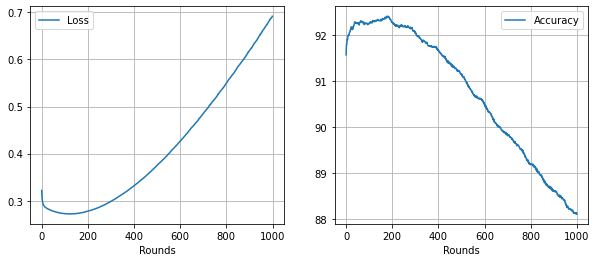

num_data: 1000
[Round: 49]  Round Loss: 0.29341971114277837  Round Acc: 92.07
[Round: 99]  Round Loss: 0.29513818509876727  Round Acc: 92.07
[Round: 149]  Round Loss: 0.2948930003494024  Round Acc: 92.08
[Round: 199]  Round Loss: 0.2949411115050316  Round Acc: 92.04
[Round: 249]  Round Loss: 0.2952639925479889  Round Acc: 91.96
[Round: 299]  Round Loss: 0.2957616075128317  Round Acc: 92.00
[Round: 349]  Round Loss: 0.2969529890269041  Round Acc: 91.93
[Round: 399]  Round Loss: 0.29840029880404473  Round Acc: 91.79
[Round: 449]  Round Loss: 0.300279006883502  Round Acc: 91.78
[Round: 499]  Round Loss: 0.30298869222402575  Round Acc: 91.72
[Round: 549]  Round Loss: 0.30531931094825265  Round Acc: 91.67
[Round: 599]  Round Loss: 0.3091479252278805  Round Acc: 91.56
[Round: 649]  Round Loss: 0.31265006072819235  Round Acc: 91.44
[Round: 699]  Round Loss: 0.3165852464735508  Round Acc: 91.28
[Round: 749]  Round Loss: 0.3218627481162548  Round Acc: 91.13
[Round: 799]  Round Loss: 0.326966051

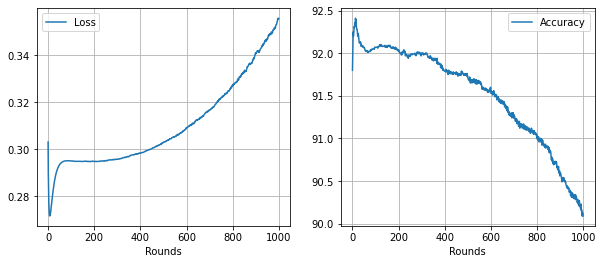

In [14]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model Capacity ====== #
args.num_epochs = 5
args.num_rounds = 1000
args.num_clients = 3
args.lr = 0.0001

args.batch_size = 100
args.hidden_dim = 15
args.num_data = 100
args.reverse = True

name_var1 = 'reverse'
name_var2 = 'num_data'

list_var1 = [False, True]
list_var2 = [100, 500, 1000]

for var1 in list_var1:
    print(f"===== {name_var1}: {var1} =====")
    setattr(args, name_var1, var1)

    for var2 in list_var2:
        print(f"{name_var2}: {var2}")
        setattr(args, name_var2, var2)

        if args.reverse == True:
            args.enc_path = f"AE_model/client = {args.num_clients}/reverse/enc_num_data_{var2}.pth"
            args.dec_path = f"AE_model/client = {args.num_clients}/reverse/dec_num_data_{var2}.pth"
        else:  
            args.enc_path = f"AE_model/client = {args.num_clients}/enc_num_data_{var2}.pth"
            args.dec_path = f"AE_model/client = {args.num_clients}/dec_num_data_{var2}.pth"

        train_set_list = data_split(args)
        partition = {'train':train_set_list, 'test':test_dataset}

        round_losses, round_acces = experiment(partition, args)
        plot_loss(round_losses, round_acces)